In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.constants import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'A2O' # Choices: ['H2Z', 'A2O', 'S2W']
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA]

In [3]:
# Load dataset
dataset_function = getattr(datasets, 'A2B')
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset apple2orange..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/A2O.pt'
=> loaded checkpoint './models/A2O.pt' (epoch 349)


In [5]:
# PGD parameters
kwargs = {
        'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 80,
        'step_size': 0.5,
        'iterations': 200,
        'do_tqdm': True,
        'targeted': True,
}

In [6]:
# Get random images from dataset
_, (img, targ) = next(data_iterator)

# Perform image-to-image translation using PGD
_, img_translated = model(img, 1 - targ, make_adv=True, **kwargs)

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

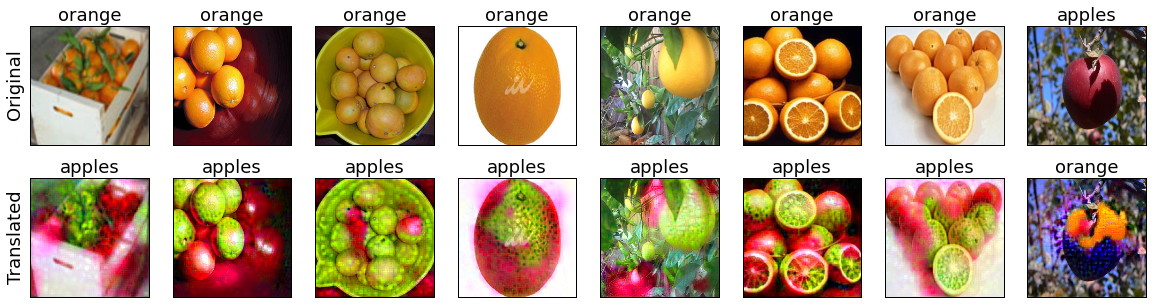

In [7]:
# Visualize image-to-image translation
show_image_row([img.cpu(), img_translated.detach().cpu()], ["Original", "Translated"], 
               tlist=[[CLASSES[int(t)] for t in targ],
                    [CLASSES[int(t)] for t in 1 - targ]],
               fontsize=18)